# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Inspect datasets

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


There are 17000 different users


Text(0, 0.5, '')

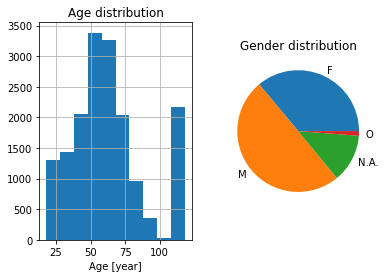

In [5]:
print(f"There are {len(set(profile['id']))} different users")
plt.figure()

plt.subplot(121)
ax = profile.age.hist()
ax.set_xlabel('Age [year]')
plt.title('Age distribution')

plt.subplot(122)
ax = profile.fillna('N.A.').groupby('gender').count()['age'].plot.pie()
plt.title('Gender distribution')
ax.set_ylabel('')

In [6]:
transcript.loc[transcript['event']=='offer received'].head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
transcript.loc[transcript['event']=='offer viewed'].head()

,person,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [8]:
transcript.loc[transcript['event']=='offer completed'].head()

,person,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [9]:
transcript.loc[transcript['event']=='offer completed'].iloc[0]['value']

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [10]:
transcript.loc[transcript['event']=='transaction'].head()

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


<AxesSubplot:>

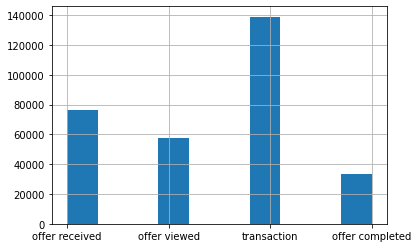

In [11]:
transcript.event.hist()

In [12]:
transcript.shape

(306534, 4)

In [13]:
# Analyze a bit offers
t = transcript[['person', 'event']]
t = t.join(pd.get_dummies(t['event']))
t2 = t.groupby('person').sum()
t2.head()

,offer completed,offer received,offer viewed,transaction
person,,,,
0009655768c64bdeb2e877511632db8f,3,5,4,8
00116118485d4dfda04fdbaba9a87b5c,0,2,2,3
0011e0d4e6b944f998e987f904e8c1e5,3,5,5,5
0020c2b971eb4e9188eac86d93036a77,3,5,3,8
0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,12


In [14]:
assert (t2['offer received']<t2['offer completed']).sum() == 0
assert (t2['offer received']<t2['offer viewed']).sum() == 0

In [15]:
# Offer completed, but not viewed!
t2.loc[(t2['offer viewed']<t2['offer completed'])]

,offer completed,offer received,offer viewed,transaction
person,,,,
004c5799adbf42868b9cff0396190900,5,5,4,12
00715b6e55c3431cb56ff7307eb19675,5,6,3,15
00840a2ca5d2408e982d56544dc14ffd,3,6,2,17
00b3400e4ff64ee68ce9ada1d0c222f0,3,5,2,10
00b3c376db2a4115af3aef34a02f61d6,3,3,2,8
...,...,...,...,...
ffa81afacde642a3a51a7cd99f8d2cd7,4,5,2,10
ffd53e5ba61d41378b66efc00d9f9682,5,5,2,12
ffdefcac307f4ca99ac1ebd51470f106,5,5,2,8


# Data Cleaning
Cleaning of the dataframes

### Cleaning portfolio

In [16]:
# Converting channels in specific dummy column 
portfolio = portfolio.join(pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0))
portfolio = portfolio.join(pd.get_dummies(portfolio['offer_type']))
portfolio['duration_hour'] = portfolio['duration'] * 24
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational,duration_hour
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,168
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,120
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1,96
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0,168
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,240


### Cleaning profile

In [17]:
# Convert become_member_on in datetime
profile['became_member_on_date'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.loc[profile['age']==118,'age'] = None
profile = profile.join(pd.get_dummies(profile['gender']))
profile['member_days'] = 1 + (profile['became_member_on_date'].max() - profile['became_member_on_date']).dt.days
profile.head()

,gender,age,id,became_member_on,income,became_member_on_date,F,M,O,member_days
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,0,0,0,530
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,1,0,0,377
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12,0,0,0,15
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,1,0,0,444
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04,0,0,0,357


### Cleaning transcript

In [18]:
# Extract offer value information
transcript = transcript.join(transcript['value'].apply(pd.Series))
transcript['offer_id'] = transcript.offer_id.combine_first(transcript['offer id'])
transcript.drop(columns=['offer id','value'], inplace=True)
transcript.drop_duplicates(inplace=True)
transcript.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [19]:
# Transaction
transaction = transcript.loc[transcript.event == 'transaction',['person','time','amount']]
transaction.head()

,person,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


Now the offer are parsed, in order to get the result of a matrix with all offer and person, with the indication if the offer is viewed and completed

In [20]:
# Merge offer received with offer description to get the duration
offer = transcript.loc[transcript.event == 'offer received',['person','time','offer_id']].merge(
    portfolio[['id','duration_hour']], left_on='offer_id', right_on='id')
offer['time_end'] = offer['time']+offer['duration_hour']
offer.drop(columns='id', inplace=True)
offer.reset_index(inplace=True)
offer_initial = offer.copy()
print(f"The shape after received is: {offer.shape}")

# Merge offer received with offer viewed
offer = offer.merge(transcript.loc[transcript.event == 'offer viewed',['person','time','offer_id']], 
                    left_on=['person','offer_id'], right_on=['person','offer_id'],
                    how='left', suffixes=('_received', '_viewed'))
offer = offer.loc[((offer['time_viewed']>=offer['time_received']) & (offer['time_viewed']<offer['time_end'])) |
                 (pd.isnull(offer['time_viewed']))]
# Add wrongly removed offer (because the same offer appear more than once on the same person)
tmp = offer_initial.loc[offer_initial['index'].isin(offer['index'])==False]
tmp = tmp.rename(columns={'time': 'time_received', 'reward': 'reward_completed'})
offer = offer.append(tmp) 
# Remove duplicates (mainy due to time equal event, or event completed before end)
offer.reset_index(drop=True, inplace=True)
offer = offer.loc[offer['index'].drop_duplicates().index]
print(f"The shape after viewed is: {offer.shape}")

# Merge offer received with offer completed
offer = offer.merge(transcript.loc[transcript.event == 'offer completed',['person','time','offer_id','reward']], 
                    left_on=['person','offer_id'], right_on=['person','offer_id'],
                    how='left', suffixes=('', '_completed'))
offer = offer.rename(columns={'time': 'time_completed', 'reward': 'reward_completed'})
offer = offer.loc[((offer['time_completed']>=offer['time_received']) & (offer['time_completed']<offer['time_end'])) |
                 (pd.isnull(offer['time_completed']))]
# Add wrongly removed offer (because the same offer appear more than once on the same person)
tmp = offer_initial.loc[offer_initial['index'].isin(offer['index'])==False]
tmp = tmp.rename(columns={'time': 'time_received', 'reward': 'reward_completed'})
offer = offer.append(tmp) 
# Remove duplicates (mainy due to time equal event, or event completed before end)
offer.reset_index(drop=True, inplace=True)
offer = offer.loc[offer['index'].drop_duplicates().index]
print(f"The shape after completed is: {offer.shape}")

offer.head()

The shape after received is: (76277, 6)
The shape after viewed is: (76277, 7)
The shape after completed is: (76277, 9)


,index,person,time_received,offer_id,duration_hour,time_end,time_viewed,time_completed,reward_completed
0,0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,168,6.0,132.0,5.0
1,2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,168,48.0,12.0,5.0
2,3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,168,30.0,66.0,5.0
3,4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,168,NaN,NaN,NaN
4,5,a3b9b4bf115e4564933ea2e4bc936843,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,168,18.0,NaN,NaN


In [21]:
# Create boolean offer
offer_bool = offer[['index','person','offer_id','time_viewed','time_completed']].copy()

# viewed and completed in boolean
offer_bool['viewed'] = False
offer_bool.loc[pd.notnull(offer_bool['time_viewed']),'viewed'] = True
offer_bool['completed'] = False
offer_bool.loc[pd.notnull(offer_bool['time_completed']),'completed'] = True

# Completed by knowing the offer
offer_bool['completed_knowing'] = False
offer_bool.loc[(offer_bool['time_viewed'] < offer_bool['time_completed']),'completed_knowing'] = True

offer_bool.drop(columns=['time_viewed','time_completed'], inplace=True)
offer_bool.head()

,index,person,offer_id,viewed,completed,completed_knowing
0,0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True
1,2,f082d80f0aac47a99173ba8ef8fc1909,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,False
2,3,c0d210398dee4a0895b24444a5fcd1d2,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,True,True
3,4,57dd18ec5ddc46828afb81ec5977bef2,9b98b8c7a33c4b65b9aebfe6a799e6d9,False,False,False
4,5,a3b9b4bf115e4564933ea2e4bc936843,9b98b8c7a33c4b65b9aebfe6a799e6d9,True,False,False


### Creating final dataframe

In [22]:
# Some numbers
offer_bool[['viewed','completed','completed_knowing']].sum()

viewed               54686
completed            33195
completed_knowing    20620
dtype: int64

In [23]:
# Calculate the boolean data for unique person/offer
offer_bool_grouped = offer_bool.groupby(['person','offer_id']).sum()
offer_bool_grouped['percentage_completed'] = offer_bool_grouped['completed_knowing'] / offer_bool_grouped['viewed']

offer_bool_grouped['working'] = None
offer_bool_grouped.loc[offer_bool_grouped['percentage_completed']>=0.5,'working'] = True
offer_bool_grouped.loc[offer_bool_grouped['percentage_completed']<0.5,'working'] = False
offer_bool_grouped.head(10)

index  \
person                           offer_id                                  
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5  22015   
                                 3f207df678b143eea3cee63160fa8bed  56225   
                                 5a8bc65990b245e5a138643cd4eb9837  70180   
                                 f19421c1d4aa40978ebb69ca19b0e20d  42206   
                                 fafdcd668e3743c1bb461111dcafc2a4  28317   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d  84546   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7  11831   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2  47257   
                                 3f207df678b143eea3cee63160fa8bed  53673   
                                 5a8bc65990b245e5a138643cd4eb9837  71497   

                                                                   viewed  \
person                           offer_id                                   
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5       0   
                                 3f207df678b143eea3cee63160fa8bed       1   
                                 5a8bc65990b245e5a138643cd4eb9837       1   
                                 f19421c1d4aa40978ebb69ca19b0e20d       1   
                                 fafdcd668e3743c1bb461111dcafc2a4       1   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d       2   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7       1   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2       1   
                                 3f207df678b143eea3cee63160fa8bed       1   
                                 5a8bc65990b245e5a138643cd4eb9837       1   

                                                                   completed  \
person                           offer_id                                      
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5          1   
                                 3f207df678b143eea3cee63160fa8bed          0   
                                 5a8bc65990b245e5a138643cd4eb9837          0   
                                 f19421c1d4aa40978ebb69ca19b0e20d          1   
                                 fafdcd668e3743c1bb461111dcafc2a4          1   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d          0   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7          1   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2          1   
                                 3f207df678b143eea3cee63160fa8bed          0   
                                 5a8bc65990b245e5a138643cd4eb9837          0   

                                                                   completed_knowing  \
person                           offer_id                                              
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5                  0   
                                 3f207df678b143eea3cee63160fa8bed                  0   
                                 5a8bc65990b245e5a138643cd4eb9837                  0   
                                 f19421c1d4aa40978ebb69ca19b0e20d                  0   
                                 fafdcd668e3743c1bb461111dcafc2a4                  0   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d                  0   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7                  1   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2                  1   
                                 3f207df678b143eea3cee63160fa8bed                  0   
                                 5a8bc65990b245e5a138643cd4eb9837                  0   

                                                                   percentage_completed  \
person                           offer_id                                                 
0009655768c64bdeb2e877511632d

In [30]:
# Combine the offer/person yes/no column with the profile and portfolio dataframes

# Get the interesting column
offer_bool_all = offer_bool_grouped[['working']].reset_index()
offer_bool_all['working_original'] = offer_bool_all['working']
offer_bool_all['working'] = offer_bool_all['working'].fillna(False)
print(f"The shape initial is: {offer_bool_all.shape}")

# Merge with portfolio
offer_bool_all = offer_bool_all.merge(portfolio.drop(columns=['channels','offer_type','duration_hour']), 
                                      left_on='offer_id', right_on='id').drop(columns='id')
print(f"The shape after portfolio merge is: {offer_bool_all.shape}")

# Merge with profile 
offer_bool_all = offer_bool_all.merge(profile.drop(columns=['became_member_on','became_member_on_date','gender']), 
                                      left_on='person', right_on='id').drop(columns='id')
print(f"The shape after profile merge is: {offer_bool_all.shape}")

offer_bool_all.head(10)

The shape initial is: (63288, 3)
The shape after portfolio merge is: (63288, 13)
The shape after profile merge is: (63288, 19)


,person,offer_id,working,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,age,income,F,M,O,member_days
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,False,2,10,7,1,1,0,1,0,1,0,33.0,72000.0,0,1,0,462
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,False,0,0,4,1,1,0,1,0,0,1,33.0,72000.0,0,1,0,462
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,False,0,0,3,1,1,1,0,0,0,1,33.0,72000.0,0,1,0,462
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,False,5,5,5,1,1,1,1,1,0,0,33.0,72000.0,0,1,0,462
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,False,2,10,10,1,1,1,1,0,1,0,33.0,72000.0,0,1,0,462
5,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,False,2,10,7,1,1,0,1,0,1,0,19.0,65000.0,1,0,0,717
6,00426fe3ffde4c6b9cb9ad6d077a13ea,5a8bc65990b245e5a138643cd4eb9837,False,0,0,3,1,1,1,0,0,0,1,19.0,65000.0,1,0,0,717
7,00426fe3ffde4c6b9cb9ad6d077a13ea,fafdcd668e3743c1bb461111dcafc2a4,True,2,10,10,1,1,1,1,0,1,0,19.0,65000.0,1,0,0,717
8,00426fe3ffde4c6b9cb9ad6d077a13ea,0b1e1539f2cc45b7b9fa7c272da2e1d7,False,5,20,10,1,0,0,1,0,1,0,19.0,65000.0,1,0,0,717
9,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,False,2,10,7,1,1,0,1,0,1,0,56.0,47000.0,0,1,0,230


## Statistical analysis

In [33]:
def plot_hist_offer_completed(df, col, subplot_number):
    '''
    Plot the specified "col" of the matrix df
    '''
    plt.subplot(subplot_number)
    df.loc[df['working']==False,col].plot.density(label='yes')
    #df.loc[pd.isnull(df['working']),col].plot.density(label='null')
    df.loc[df['working']==True,col].plot.density(label='no')

    plt.title('Comparison of offer acceptance')
    plt.xlabel(col)
    plt.legend()

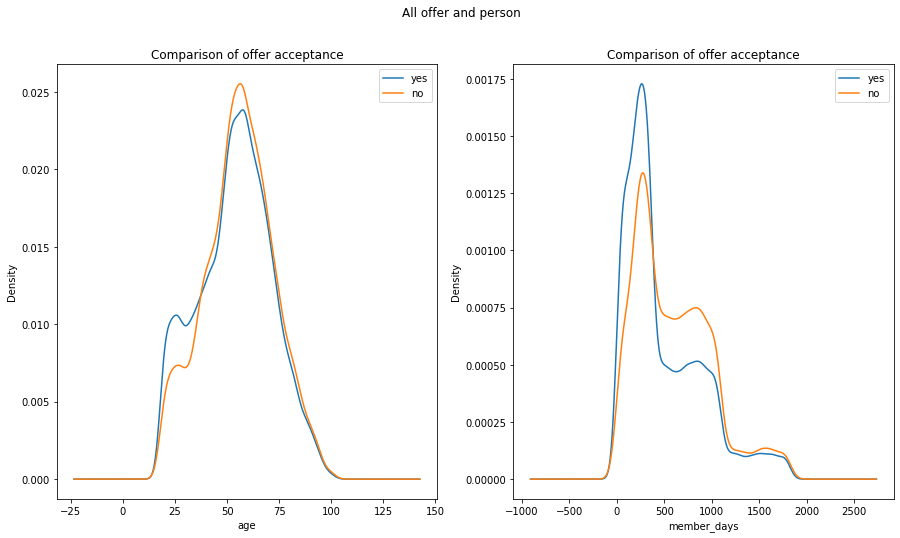

In [34]:
# Plot of all
plt.figure(figsize=(15,8))
plt.suptitle('All offer and person')
plot_hist_offer_completed(offer_bool_all, 'age', 121)
plot_hist_offer_completed(offer_bool_all, 'member_days', 122)

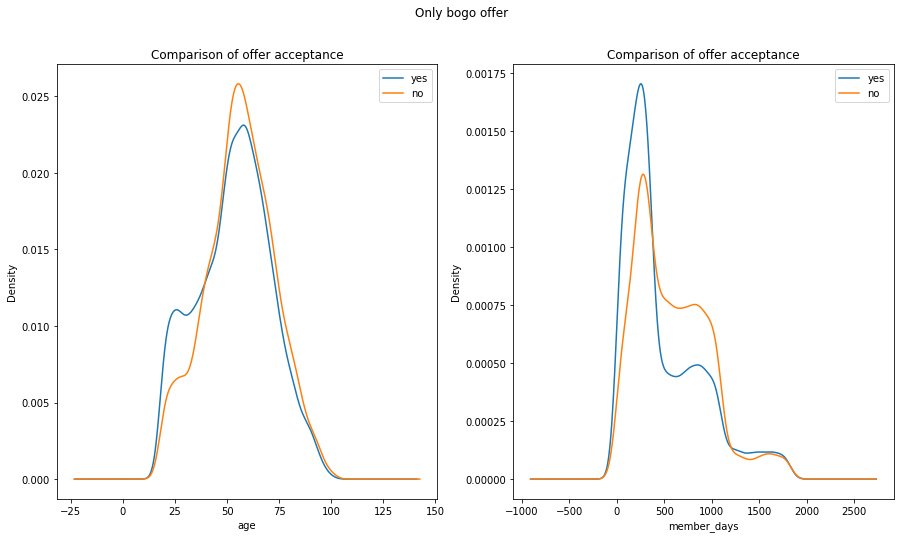

In [35]:
# Plot of specific offer
plt.figure(figsize=(15,8))
plt.suptitle('Only bogo offer')
plot_hist_offer_completed(offer_bool_all.loc[offer_bool_all['bogo']==1], 'age', 121)
plot_hist_offer_completed(offer_bool_all.loc[offer_bool_all['bogo']==1], 'member_days', 122)

In [36]:
offer_bool_all

,person,offer_id,working,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational,age,income,F,M,O,member_days
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,False,2,10,7,1,1,0,1,0,1,0,33.0,72000.0,0,1,0,462
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,False,0,0,4,1,1,0,1,0,0,1,33.0,72000.0,0,1,0,462
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,False,0,0,3,1,1,1,0,0,0,1,33.0,72000.0,0,1,0,462
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,False,5,5,5,1,1,1,1,1,0,0,33.0,72000.0,0,1,0,462
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,False,2,10,10,1,1,1,1,0,1,0,33.0,72000.0,0,1,0,462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,930305f046fa4f218d2539fb99baefb9,ae264e3637204a6fb9bb56bc8210ddfd,False,10,10,7,1,1,1,0,1,0,0,68.0,38000.0,0,1,0,1685
63284,948ec827ac334c8782a1da99a2d6a39b,ae264e3637204a6fb9bb56bc8210ddfd,True,10,10,7,1,1,1,0,1,0,0,61.0,44000.0,0,1,0,931
63285,d957b9bd21fd4cacb39aab4b2834704b,ae264e3637204a6fb9bb56bc8210ddfd,False,10,10,7,1,1,1,0,1,0,0,82.0,84000.0,1,0,0,100
63286,eb21d0838df54a55b85814108393903f,ae264e3637204a6fb9bb56bc8210ddfd,False,10,10,7,1,1,1,0,1,0,0,31.0,69000.0,0,1,0,188
